# Point spread function

**WARNING**

This is still a work-in-progress, it will evolve with the pipeline comparisons and converge with ctaplot+cta-benchmarks.

**Author(s):**
    
- Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

based on previous work by J. Lefacheur.

**Description:**

This notebook contains benchmarks for the _protopipe_ pipeline regarding the angular distribution of the showers selected for DL3 data.

Note that:
    - a more general set of benchmarks is being defined in cta-benchmarks/ctaplot,
    - follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding new benchmarks or proposing new ones.

**Requirements:**

To run this notebook you will need a set of DL2 data produced on the grid with protopipe.
The MC production to be used and the appropriate set of files to use for this notebook can be found [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#The-MC-sample ).

The data format required to run the notebook is the current one used by _protopipe_ .
Later on it will be the same as in _ctapipe_ + _pyirf_.

**Development and testing:**  

For the moment this notebook is optimized to work only on files produced from LSTCam + NectarCam telescope configurations.  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.  
**IMPORTANT:** Please, if you wish to contribute to this notebook, before pushing anything to your branch (better even before opening the PR) clear all the output and remove any local directory paths that you used for testing (leave empty strings).

**TODO:**  
* update everything...
* add remaining benchmarks from CTA-MARS comparison
* same for EventDisplay

## Imports

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
cmap = dict()
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, PowerNorm
count = 0
for key in colors.cnames:
    if 'dark' in key:
    #if key in key:
        cmap[count] = key
        count = count + 1
#cmap = {'black': 0, 'red': 1, 'blue': 2, 'green': 3}
cmap = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}
import os
import numpy as np
import pandas as pd

import astropy.coordinates as c
import astropy.wcs as wcs
import astropy.units as u
import matplotlib.pyplot as plt
from pathlib import Path

## Functions

In [2]:
def compute_psf(data, ebins, radius):
    nbin = len(ebins) - 1
    psf = np.zeros(nbin)
    psf_err = np.zeros(nbin)
    for idx in range(nbin):
        emin = ebins[idx]
        emax = ebins[idx+1]
        sel = data.loc[(data['mc_energy'] >= emin) & (data['mc_energy'] < emax), ['xi']]
        if len(sel) != 0:
            psf[idx] = np.percentile(sel['xi'], radius)
            psf_err[idx] = psf[idx] / np.sqrt(len(sel))
        else:
            psf[idx] = 0.
            psf_err[idx] = 0.
    return psf, psf_err

def plot_psf(ax, x, y, err, **kwargs):
    color = kwargs.get('color', 'red')
    label = kwargs.get('label', '')
    xlabel = kwargs.get('xlabel', '')
    xlim = kwargs.get('xlim', None)
    
    ax.errorbar(x, y, yerr=err, fmt='o', label=label, color=color) #, yerr=err, fmt='o') #, color=color, label=label)
    ax.set_ylabel('PSF (68% containment)')
    ax.set_xlabel('True energy [TeV]')
    if xlim is not None:
        ax.set_xlim(xlim)
    return ax

## Load data

First we check if a _plots_ folder exists already.  
If not, we create it.

In [5]:
Path("./plots_DL3").mkdir(parents=True, exist_ok=True)

In [7]:
# Please, if you modify this notebook in a PR cleanup these two variables
parent = '/Users/michele/Applications/ctasoft/dirac/data/analyses' # your analysis parent folder (better use an absolute path)
config = 'protopipe_021dev_ctapipe070' # analysis descriptor to be used as suffix in the plots

data_dir = f'{parent}/{config}/data/DL2'
data_file = 'DL2_tail_gamma_merged.h5'
data_evt = pd.read_hdf(os.path.join(data_dir, data_file), "/reco_events")

## Benchmarks

### Point Spread Function (PSF)

**Note:** only multiplicity cuts are applied here; it seems that also CTAMARS sees these bumps and that they tend to disappear with g/h cuts

<Figure size 2000x2000 with 0 Axes>

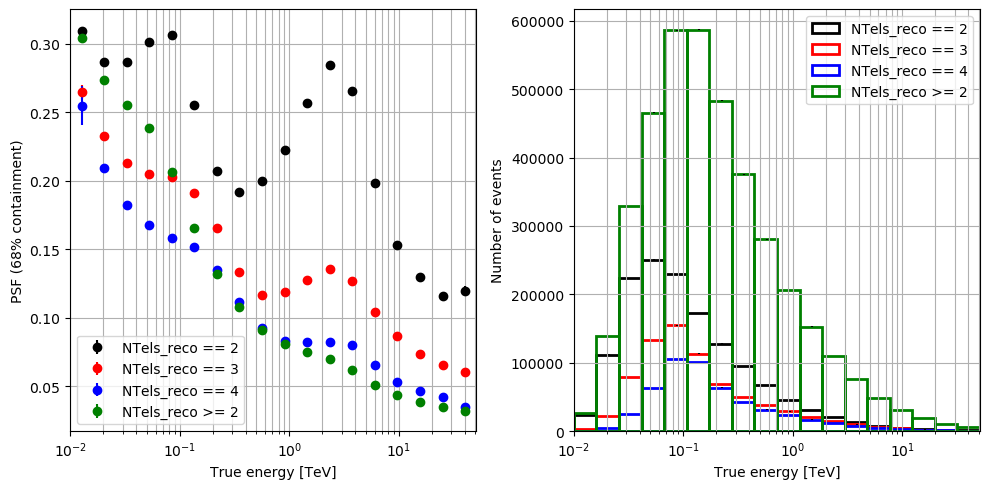

In [16]:
r_containment = 68

energy_edges = np.logspace(np.log10(0.01), np.log10(51), 18 + 1, True)
energy = np.sqrt(energy_edges[1:] * energy_edges[:-1])
multiplicity_cuts = ['NTels_reco == 2','NTels_reco == 3', 'NTels_reco == 4', 'NTels_reco >= 2']

plt.figure(figsize=(20,20))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes = axes.flatten()

cmap = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}

limit = [0.01, 51]
for cut_idx, cut in enumerate(multiplicity_cuts):
    data_mult = data_evt.query(cut)
    psf, err_psf = compute_psf(data_mult, energy_edges, 68)
    opt={'color': cmap[cut_idx], 'label': multiplicity_cuts[cut_idx]}
    plot_psf(axes[0], energy, psf, err_psf, **opt)
    
    y, tmp = np.histogram(data_mult['mc_energy'], bins=energy_edges)
    weights = np.ones_like(y)
    #weights = weights / float(np.sum(y))
    yerr = np.sqrt(y) * weights
    centers = 0.5 * (energy_edges[1:] + energy_edges[:-1])
    width = energy_edges[1:] - energy_edges[:-1]
    axes[1].bar(centers, y * weights, width=width, yerr=yerr, **{'edgecolor': cmap[cut_idx], 'label': multiplicity_cuts[cut_idx], 'lw': 2, 'fill': False})
    axes[1].set_ylabel('Number of events')
    
for ax in axes:
    ax.set_xlim(limit)
    ax.set_xscale('log')
    ax.legend(loc='best')
    ax.grid(which='both')
    ax.set_xlabel('True energy [TeV]')

plt.tight_layout()
plt.show()

fig.savefig(f"./plots_DL3/PSF_{config}.png")

### PSF asymmetry

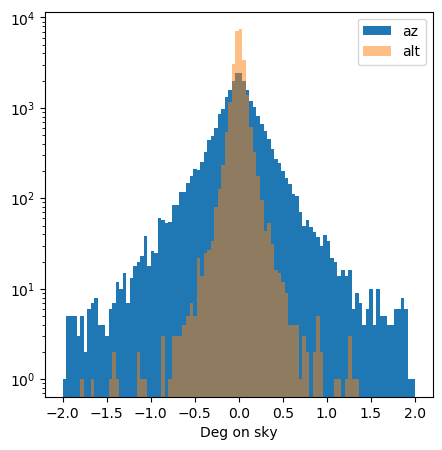

In [39]:
data = data_evt[ (data_evt.mc_energy > 0.05) & (data_evt.NTels_reco_lst > 2) ].copy().head(26013)
# data.loc[data_evt.reco_az<-180, 'reco_az'] += 360.0
# data['reco_az_sky'] = data.reco_az * np.cos(np.deg2rad(data.reco_alt))

CENTER_ALT_DEG = 70.0
CENTER_AZ_DEG = -180.0

dalt = data.reco_alt - CENTER_ALT_DEG
# daz = data.reco_az_sky - CENTER_AZ_DEG
daz = data.reco_az - CENTER_AZ_DEG


the_range = [-2,2]
plt.figure(figsize=(5,5))
plt.semilogy()

plt.hist(daz, bins=100, range=the_range, label='az')
plt.hist(dalt, bins=100, range=the_range, alpha=0.5, label='alt')

plt.xlabel("Deg on sky")
plt.legend()

fig.savefig(f"./plots_DL3/PSFasymmetry_altaz_{config}.png")

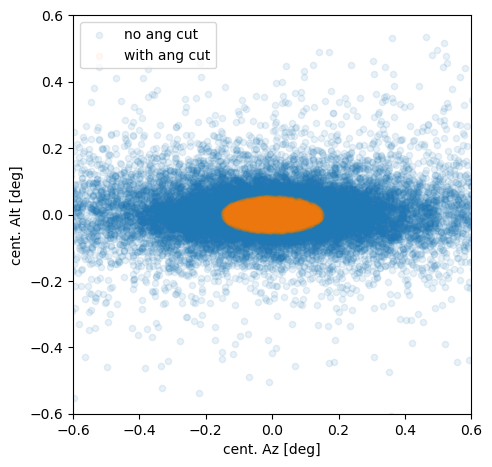

In [41]:
angcut = data['offset'] < 0.05
dx = 0.3

plt.figure(figsize=(5,5))

ax = plt.gca()

scale=20

ax.scatter(daz, dalt, alpha=0.1, s=scale, label='no ang cut')
ax.scatter(daz[angcut], dalt[angcut], alpha=0.05, s=scale, label='with ang cut')

ax.set_aspect('equal')
ax.set_xlim(-2*dx,2*dx)
ax.set_ylim(-2*dx,2*dx)

ax.set_xlabel('cent. Az [deg]')
ax.set_ylabel('cent. Alt [deg]')

ax.legend()
plt.tight_layout()

fig.savefig(f"./plots_DL3/PSFasymmetry_2D_altaz_{config}.png")

In [ ]:
print('daz = {:.4f} +/- {:.4f}'.format(daz.mean(), daz.std()))
print('dalt = {:.4f} +/- {:.4f}'.format(dalt.mean(), dalt.std()))